In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [133]:
# Load data from CSV
train_data = pd.read_csv('train.csv', delimiter=';')

## Exploratory Data Analysis

### Histogram zu `customerType` und `totalAmount`

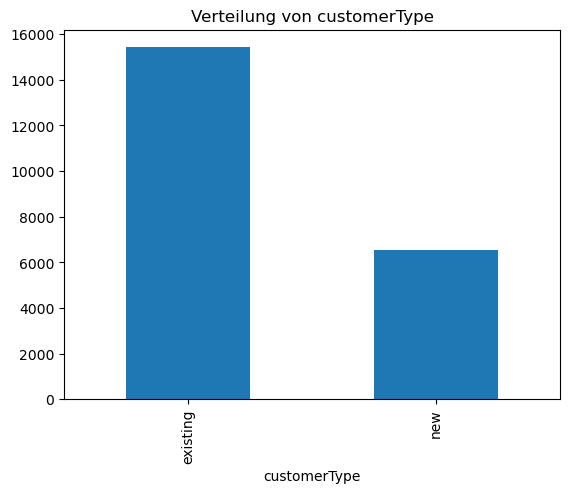

In [134]:
# Count how many instances of a new or existing customer are in the dataset and plot it as a bar chart
# We used .value_counts().plot() instead of .hist() to get a more readable bar chart
train_data['customerType'].value_counts().plot(kind='bar', title='Verteilung von customerType')
plt.show()

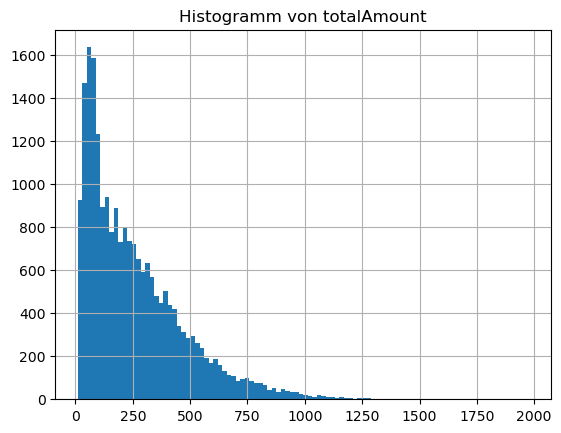

In [135]:
# Plot the histogram of the totalAmount column with an resolution of 100
train_data['totalAmount'].hist(bins=100)
plt.title('Histogramm von totalAmount')
plt.show()

### Verteilung von `returnLabel` über alle Daten

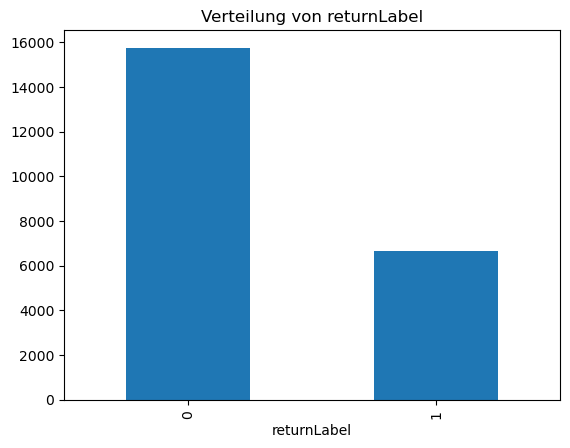

In [136]:
# Plot a bar chart of the distribution of the different return label values
train_data['returnLabel'].value_counts().plot(kind='bar', title='Verteilung von returnLabel')
plt.show()

### Verteilung von `returnLabel` in Abhängigkeit zu allen Ausprägungen von `customerType`

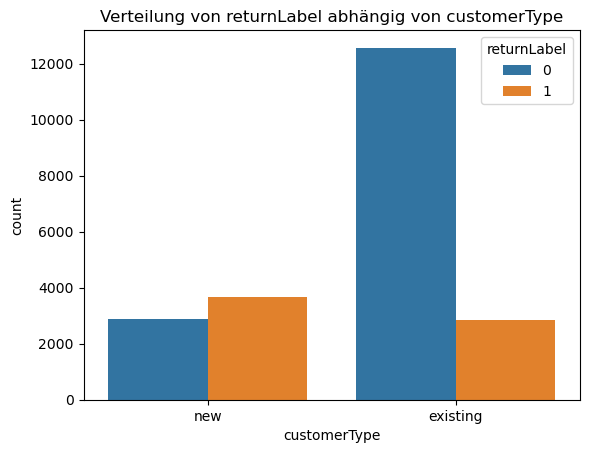

In [137]:
# Plot a combined count plot of the variables customerType and returnLabel as they relate to each other
sns.countplot(data=train_data, x='customerType', hue='returnLabel')
plt.title('Verteilung von returnLabel abhängig von customerType')
plt.show()

### Boxplot für `totalAmount` in Abhängigkeit des Labels

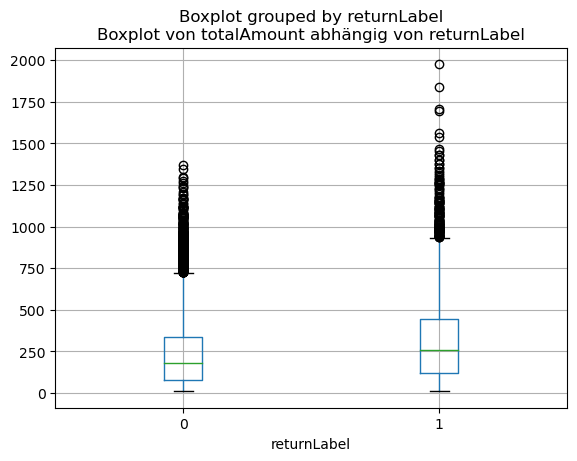

In [138]:
# Plot a boxplot of the totalAmount column for each returnLabel
train_data.boxplot(column='totalAmount', by='returnLabel')
plt.title('Boxplot von totalAmount abhängig von returnLabel')
plt.show()

### Displot für `totalAmount` in Abhängigkeit des Labels

/opt/homebrew/Caskroom/miniconda/base/envs/ml-course/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


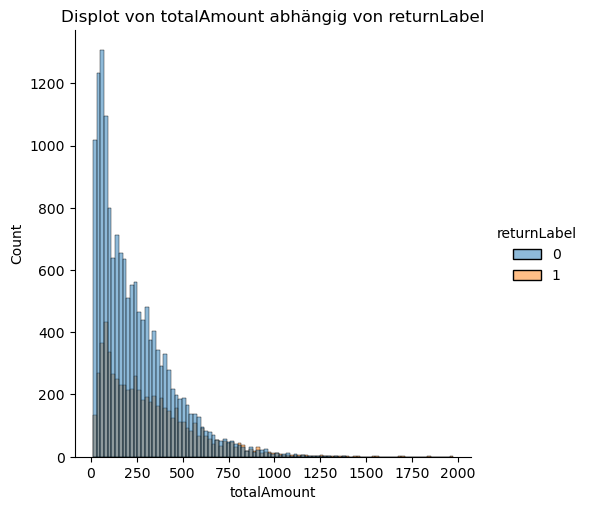

In [139]:
# Plot a density plot of the totalAmount variable for each returnLabel value
sns.displot(data=train_data, x='totalAmount', hue='returnLabel')
plt.title('Displot von totalAmount abhängig von returnLabel')
plt.show()

## Auffüllen fehlender Werte

In [140]:
# Fill missing values in totalAmount column
train_data['totalAmount'] = train_data['totalAmount'].fillna(train_data['totalAmount'].median())

## One-Hot-Encoding für customerType & Feature Engineering mit `basket`

In [141]:
# This function prepares the data so the model can either be trained or tested on a given dataset
# It performs multiple data transformations on the dataframe
def prepareData(df):
    # The model cannot be trained on the string values of "new" and "existing" as they are not numerical values
    # So we create dummy rows for each customer type => these are then customerType_existing: boolean and customerType_new: boolean
    df = pd.get_dummies(df, columns=['customerType'])

    # The model can also not be trained on the array values of the basket so we need to transform this in some way
    # We count the number of times each category appears in the basket and then create a new column `category_i_count` for each category containing it's count
    if 'basket' in df.columns:
        for i in range(6):
            df[f'category_{i}_count'] = df['basket'].apply(lambda x: x.count(str(i)))
        df.drop(columns=['basket'], inplace=True)
    return df

In [142]:
# Prepare the loaded training data
train_data = prepareData(train_data)

# Make sure that the data transformations are correct
train_data.head()

,transactionId,totalAmount,returnLabel,customerType_existing,customerType_new,category_0_count,category_1_count,category_2_count,category_3_count,category_4_count,category_5_count
0,9534310106,252.0,1,False,True,0,0,0,1,2,0
1,7202594767,70.0,0,True,False,1,0,2,0,1,1
2,2737331698,84.0,0,True,False,0,0,0,0,0,1
3,4868011733,116.0,0,True,False,0,1,1,0,2,0
4,7622406570,378.0,0,True,False,1,0,3,2,0,1


## Skalieren der Features

In [143]:
# Create an instance of the StandardScaler which is used both in training and in testing
scaler = StandardScaler()

# We need to scale totalAmount, the category_i_count columns and the category_i_amount columns, so we select them here
features_to_scale = ['totalAmount', 'category_0_count', 'category_1_count', 'category_2_count', 'category_3_count', 'category_4_count', 'category_5_count']

# Now we let the scaler transform the selected features on the training data
train_data[features_to_scale] = scaler.fit_transform(train_data[features_to_scale])

train_data.head()

,transactionId,totalAmount,returnLabel,customerType_existing,customerType_new,category_0_count,category_1_count,category_2_count,category_3_count,category_4_count,category_5_count
0,9534310106,-0.027351,1,False,True,-0.771563,-0.767737,-0.775046,0.075189,0.634586,-0.644106
1,7202594767,-0.873409,0,True,False,0.383487,-0.767737,1.514422,-0.880132,-0.122402,0.527090
2,2737331698,-0.808327,0,True,False,-0.771563,-0.767737,-0.775046,-0.880132,-0.879391,0.527090
3,4868011733,-0.659570,0,True,False,-0.771563,0.391580,0.369688,-0.880132,0.634586,-0.644106
4,7622406570,0.558381,0,True,False,0.383487,-0.767737,2.659156,1.030510,-0.879391,0.527090


## Trainieren der Klassifikationsmodelle

In [144]:
# Create a dataframe from the initial data without the returnLabel column
# axis=1 specifies that the first column is the index
X = train_data.drop(['transactionId', 'returnLabel'], axis=1)

# Create another dataframe from the initial data with the returnLabel column
y = train_data['returnLabel']

### Logistische Regression

In [145]:
log_reg_params = {'C': [0.1, 1, 4, 5, 6, 10, 30, 100], 'penalty': ['l1', 'l2']}
best_log_reg = None
best_score = 0

# To find the best parameters for logistic regression we can use cross validation and iterate over the different parameters
for C in log_reg_params['C']:
    for penalty in log_reg_params['penalty']:
        try:
            # Create a logistic regression model with the given parameters of the current iteration
            # Use the liblinear solver to train the model
            log_reg = LogisticRegression(C=C, penalty=penalty, solver='liblinear', max_iter=1000)
            # Calculate the cross validation score of the model
            scores = cross_val_score(log_reg, X, y, scoring='accuracy')
            # Calculate the mean score of the cross validation
            mean_score = scores.mean()
            # If the current model is better than the previous best model, update the best model
            if mean_score > best_score:
                best_score = mean_score
                best_log_reg = log_reg
        except Exception as e:
            continue

### Random Forest

In [146]:
rf_params = {'n_estimators': [60, 80, 100, 120, 140], 'max_depth': [2, 4, 6]}
best_rf = None
best_score_rf = 0

# To find the best parameters for the Random Forest classifier we can use cross validation and iterate over the different parameters.
for n_estimators in rf_params['n_estimators']:
    for max_depth in rf_params['max_depth']:
        # Create a Random Forest classifier with the given parameters
        rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
        # Calculate the cross-validation score for the Random Forest classifier
        scores = cross_val_score(rf, X, y, scoring='accuracy')
        # Calculate the mean score of the cross-validation scores
        mean_score = scores.mean()
        # If the current model is better than the previous best model, update the best model
        if mean_score > best_score_rf:
            best_score_rf = mean_score
            best_rf = rf

### Gradient Boosting Tree

In [147]:
gbt_params = rf_params
best_gbt = None
best_score = 0

# To find the best parameters for Gradient Boosting Classifier we can use cross validation and iterate over the different parameters
for n_estimators in gbt_params['n_estimators']:
    for max_depth in gbt_params['max_depth']:
        # Create a Gradient Boosting Classifier
        gbt = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth)
        # Calculate the cross validation score for the Gradient Boosting Classifier
        scores = cross_val_score(gbt, X, y, scoring='accuracy')
        # Calculate the mean score of the cross-validation scores
        mean_score = scores.mean()
        # If the current model is better than the previous best model, update the best model
        if mean_score > best_score:
            best_score = mean_score
            best_gbt = gbt

In [148]:
# Load the test data and drop the rows with missing values
test_data = pd.read_csv('test.csv', delimiter=';')
test_data.dropna(inplace=True)

In [149]:
# Run the same data transformations as on the training data
test_data = prepareData(test_data)

test_data.head()

,transactionId,totalAmount,returnLabel,customerType_existing,customerType_new,category_0_count,category_1_count,category_2_count,category_3_count,category_4_count,category_5_count
0,4132523932,366.0,1,True,False,0,0,1,3,2,0
1,8998574539,85.0,0,True,False,0,0,0,2,2,1
2,9346688547,275.0,0,True,False,1,4,2,2,2,0
3,4533897707,528.0,0,True,False,1,3,2,1,0,1
4,3334800500,287.0,0,True,False,0,1,2,1,1,2


In [150]:
# Scale the test_data features that need to be scaled
test_data[features_to_scale] = scaler.transform(test_data[features_to_scale])

In [151]:
# Create a new dataframe of the test_data without the returnLabel and transactionId columns
X_test = test_data.drop(columns=['transactionId', 'returnLabel'], axis=1)

# Create a prediction based on the best logistic regression model
best_log_reg.fit(X, y)
logistic_regression_predictions = best_log_reg.predict(X_test)

# Create a prediction based on the best random forest model
best_rf.fit(X, y)
random_forest_predictions = best_rf.predict(X_test)

# Create a prediction based on the best gradient boosting tree model
best_gbt.fit(X, y)
gradient_boosting_tree_predictions = best_gbt.predict(X_test)

In [152]:

# Calculate the accuracy, precision, and recall of the different models using the accuracy_score, precision_score, and recall_score functions
logistic_regression_accuracy = accuracy_score(test_data['returnLabel'], logistic_regression_predictions)
logistic_regression_precision = precision_score(test_data['returnLabel'], logistic_regression_predictions, zero_division=1)
logistic_regression_recall = recall_score(test_data['returnLabel'], logistic_regression_predictions)

random_forest_accuracy = accuracy_score(test_data['returnLabel'], random_forest_predictions)
random_forest_precision = precision_score(test_data['returnLabel'], random_forest_predictions, zero_division=1)
random_forest_recall = recall_score(test_data['returnLabel'], random_forest_predictions)

gradient_boosting_tree_accuracy = accuracy_score(test_data['returnLabel'], gradient_boosting_tree_predictions)
gradient_boosting_tree_precision = precision_score(test_data['returnLabel'], gradient_boosting_tree_predictions, zero_division=1)
gradient_boosting_tree_recall = recall_score(test_data['returnLabel'], gradient_boosting_tree_predictions)

print(f'Logistic Regression - Accuracy: {logistic_regression_accuracy}, Precision: {logistic_regression_precision}, Recall: {logistic_regression_recall}')
print(f'Random Forest - Accuracy: {random_forest_accuracy}, Precision: {random_forest_precision}, Recall: {random_forest_recall}')
print(f'Gradient Boosting Tree - Accuracy: {gradient_boosting_tree_accuracy}, Precision: {gradient_boosting_tree_precision}, Recall: {gradient_boosting_tree_recall}')

Logistic Regression - Accuracy: 0.8729676999783221, Precision: 0.8174157303370787, Recall: 0.7396514161220044
Random Forest - Accuracy: 0.8609364838499891, Precision: 0.7966922146026624, Recall: 0.7171387073347858
Gradient Boosting Tree - Accuracy: 0.8728593106438326, Precision: 0.8029896512073591, Recall: 0.760711692084241


In [155]:
# Accuracy on training data
logistic_regression_training_accuracy = best_log_reg.score(X, y)
random_forest_training_accuracy = best_rf.score(X, y)
gradient_boosting_tree_training_accuracy = best_gbt.score(X, y)

# Print training accuracy
print(f"Logistic Regression - Training Accuracy: {logistic_regression_training_accuracy}")
print(f"Random Forest - Training Accuracy: {random_forest_training_accuracy}")
print(f"Gradient Boosting Tree - Training Accuracy: {gradient_boosting_tree_training_accuracy}")

# Check for overfitting using train/test split
overfitting_logistic_regression_amount = logistic_regression_training_accuracy - logistic_regression_accuracy
overfitting_random_forest_amount = random_forest_training_accuracy - random_forest_accuracy
overfitting_gradient_boosting_tree_amount = gradient_boosting_tree_training_accuracy - gradient_boosting_tree_accuracy

print(f"Logistic Regression Overfitting by: {overfitting_logistic_regression_amount}")
print(f"Random Forest Overfitting by: {overfitting_random_forest_amount}")
print(f"Gradient Boosting Tree Overfitting by: {overfitting_gradient_boosting_tree_amount}")

Logistic Regression - Training Accuracy: 0.8788839285714286
Random Forest - Training Accuracy: 0.8726785714285714
Gradient Boosting Tree - Training Accuracy: 0.8859375
Logistic Regression Overfitting by: 0.005916228593106476
Random Forest Overfitting by: 0.011742087578582305
Gradient Boosting Tree Overfitting by: 0.013078189356167447


In [162]:
# Create a set for each model's misclassified points
log_reg_misclassified = set(test_data.index[logistic_regression_predictions != test_data['returnLabel']])

rf_misclassified = set(test_data.index[random_forest_predictions != test_data['returnLabel']])

gbt_misclassified = set(test_data.index[gradient_boosting_tree_predictions != test_data['returnLabel']])

# Concatenate the sets to get all commonly misclassified points
common_misclassified = log_reg_misclassified & rf_misclassified & gbt_misclassified

# Number of commonly misclassified points
print(f"Number of commonly misclassified points: {len(common_misclassified)}; Percentage: {len(common_misclassified) / len(test_data)}")

Number of commonly misclassified points: 922; Percentage: 0.09993496639930631
